In [1]:
import networkit as nk
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
import simulated_annealing_core as sa

## Introduction

In this notebook we give an example of how to use simulated annealing to solve the integer traffic assignment problem (ITAP).
Our method consists in looping thorugh paths and thermalizing each path with the others fixed. 
This is repeated several times while decreasing a temperature parameter.


In this example we apply simulated annealing to the case of a random regular graph qith origin-destination pairs picked uniformly at random (but with the constraint of the origin being distinct from the destination)

### Auxiliary functions
Stuff for plotting

In [2]:
#auxiliary functions to plot the network and the paths
def Plot_network(G): 
    to_plot_graph = nx.Graph()
    N=G.numberOfNodes()
    print(G.numberOfNodes())
    for i in range(N):
        to_plot_graph.add_node(i)
    for u,v in G.iterEdges():
        to_plot_graph.add_edge(u,v)

    weights = [(G.weight(u,v)) for u,v in G.iterEdges()]
    pos= nx.circular_layout(to_plot_graph)
    nx.draw(to_plot_graph,with_labels=True ,width = weights,pos=pos)
    plt.show()


def Plot_network_paths(G, paths): 
    N=G.numberOfNodes()
    G=copy.deepcopy(G) 
    for u,v in G.iterEdges():
        G.setWeight(u,v,1)
    for path in paths:
        for k in range(len(path)-1):
            G.setWeight(path[k],path[k+1],G.weight(path[k],path[k+1])+1)
    to_plot_graph = nx.Graph()
    for i in range(N):
        to_plot_graph.add_node(i)
    for u,v in G.iterEdges():
        to_plot_graph.add_edge(u,v,weight=(G.weight(u,v)))
        
    weights = np.log(np.array([(G.weight(u,v)) for u,v in G.iterEdges()])) #removing the logarithm will givethe whle graph, with thicker edges being those that get traversed the most.
    pos= nx.circular_layout(to_plot_graph)
    nx.draw(to_plot_graph,with_labels=True ,pos=pos,width=weights)
    plt.show()

## Graph generation
Generate the graph using the random regualr graph generator from networkx, then convert it into a networkit graph.

30


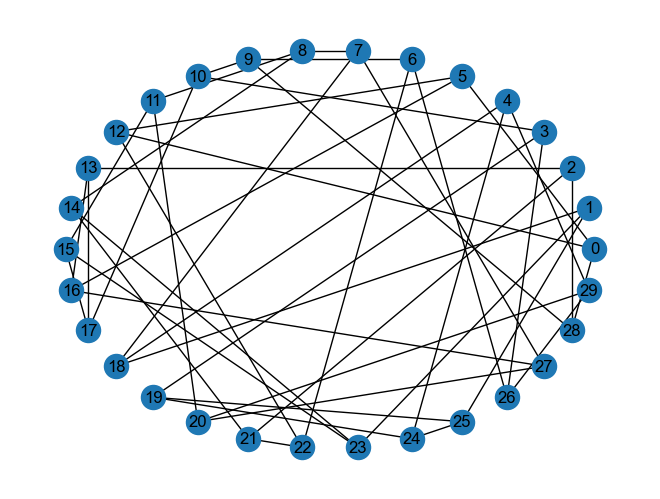

In [3]:
#generate random regular graph
N=30 #number of nodes
degree=3 #degree of each node
nx_G=nx.random_regular_graph(d=degree, n=N,seed=1) #generate using networkx library

# To convert my networkx into networkit
G = nk.Graph(n=N, weighted=True, directed=False)
for edge in nx_G.edges():
    G.addEdge(edge[0],edge[1]) 
    G.setWeight(edge[0],edge[1],1)

#plot the graph
if(N<=50 and degree<30):
    Plot_network(G)

## Generate origin destination pairs
A total of $M$ pairs is generated by picking each time two random distinct nodes in the graph

In [4]:
#generate random sources and destinations
M=60 #number of paths
start_nodes=[]
end_nodes=[]
for i in range(M):
    start_node,end_node=np.random.choice(N,2,replace=False)    
    start_nodes.append(start_node)
    end_nodes.append(end_node)


print("The sources are : ")
print(start_nodes)
print("The destinations are : ")
print(end_nodes)

#transform G into an undirected weighted graph
G = nk.graphtools.toWeighted(G)  #maybe check if weights on nodes

#------------------------------------------------------------------------------------------------------------------------------------ 
#cost function: when computing the total cost you will just use :phi(flow)
def phi(x,gamma):
    return x**(gamma)

The sources are : 
[13, 11, 25, 0, 13, 29, 15, 23, 13, 18, 26, 15, 16, 19, 15, 25, 1, 8, 5, 14, 18, 26, 14, 26, 9, 9, 5, 5, 7, 5, 13, 13, 21, 14, 21, 19, 4, 24, 15, 26, 23, 20, 12, 16, 10, 2, 27, 23, 4, 24, 11, 21, 4, 19, 24, 24, 1, 14, 29, 11]
The destinations are : 
[5, 15, 3, 11, 20, 22, 13, 16, 20, 29, 10, 26, 4, 26, 2, 7, 22, 11, 9, 27, 12, 29, 26, 21, 11, 28, 3, 7, 4, 23, 16, 4, 1, 8, 25, 14, 29, 21, 9, 4, 5, 16, 17, 10, 11, 16, 8, 9, 2, 22, 13, 1, 8, 3, 2, 5, 24, 3, 1, 20]


# Simulated annealing Routing
We set the parameters of the simulated annealing algorithm (annealing schedule, mcmc steps per path) 
Then we run the algorithm.

In [5]:
beta_min=4
annealing_steps=40
beta_schedule=beta_min*(annealing_steps)/(annealing_steps-np.arange(0,annealing_steps)) #schedule that starts at beta_min and goes to infinity in annealing_steps steps.
#beta_schedule=[1e10 for i in range(annealing_steps)] #using this alternative schedule one reproduces the greedy algorithm
beta_schedule_all_mcmc=np.concatenate((beta_schedule,1e10*np.ones(10))) #after the anealing schedule reaches beta=infinity, we do 10 more steps with beta=infinity to make sure we converge.
mcmc_steps=10 #steps to be done when sampling a single path with the SAW sampler. That is, in each annealing step, for each path we do mcmc_steps steps of the SAW sampler.
gamma=0.5 #parameter of the cost function

In [6]:
print("annealed algo")
annealed_paths, flag_conv=sa.annealed_optimizer(G,start_nodes,end_nodes,beta_schedule=beta_schedule_all_mcmc,phi=lambda x: phi(x,gamma) ,mcmc_steps=mcmc_steps,mcmc_seed=None,quiet=False)
print(flag_conv)

annealed algo
t=0, beta=4.00e+00, energy=84.95724285900675


t=1, beta=4.10e+00, energy=97.27001967033416


/Users/piccioli/Library/CloudStorage/Dropbox/optimal_routing/code/repo_algorithms_optimal_routing/simulated_annealing/saw_sampler_core.py:61: RuntimeWarning: overflow encountered in multiply
  P_trans=np.exp(-beta*C_path_y)


t=2, beta=4.21e+00, energy=103.94446214713864


/Users/piccioli/Library/CloudStorage/Dropbox/optimal_routing/code/repo_algorithms_optimal_routing/simulated_annealing/saw_sampler_core.py:124: RuntimeWarning: overflow encountered in multiply
  log_P_trans=-beta*C_path_y


t=3, beta=4.32e+00, energy=103.63785244929139
t=4, beta=4.44e+00, energy=101.81591869917816
t=5, beta=4.57e+00, energy=96.18392720735385
t=6, beta=4.71e+00, energy=95.6495789772478
t=7, beta=4.85e+00, energy=94.87404845197838
t=8, beta=5.00e+00, energy=93.52543280702584
t=9, beta=5.16e+00, energy=89.51405497087295
t=10, beta=5.33e+00, energy=86.60819956622666
t=11, beta=5.52e+00, energy=88.04323056247839
t=12, beta=5.71e+00, energy=83.58091725326236
t=13, beta=5.93e+00, energy=85.82380074520259
t=14, beta=6.15e+00, energy=84.50478843562175
t=15, beta=6.40e+00, energy=86.76249493120615
t=16, beta=6.67e+00, energy=84.84268862726083
t=17, beta=6.96e+00, energy=83.90987949464308
t=18, beta=7.27e+00, energy=82.10609125924707
t=19, beta=7.62e+00, energy=81.37476783271251
t=20, beta=8.00e+00, energy=80.14827660822462
t=21, beta=8.42e+00, energy=80.53656824175988
t=22, beta=8.89e+00, energy=80.31097608951146
t=23, beta=9.41e+00, energy=80.64609731845455
t=24, beta=1.00e+01, energy=79.189162338

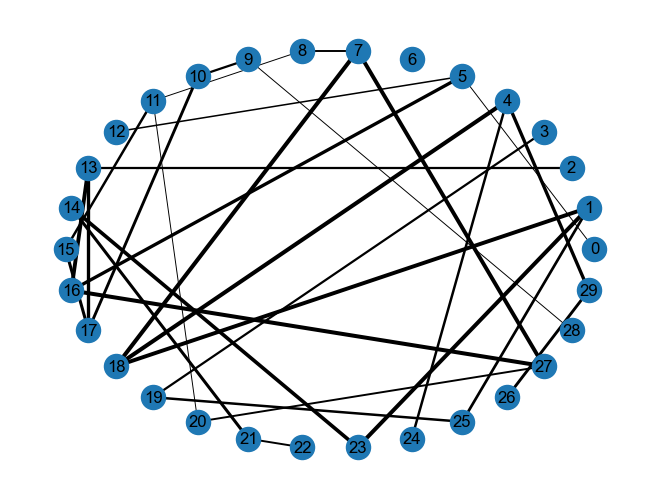

In [7]:
#plotting the flow (traffic) on the edges of the network
Plot_network_paths(G, annealed_paths)